In [1]:
# ============================================================
# 004_PDF_to_Slides_AutoSummary
# ============================================================
#
# Overview
# --------
# This notebook converts a research paper in PDF format into a set of
# presentation-ready slide images using large language and image models.
#
# The workflow is intentionally simplified:
# - Text is extracted and summarized into structured sections.
# - Each section is transformed into a *single, complete slide image*
#   generated directly by Gemini (including title, message text, and diagram).
# - No post-processing or manual layout composition is performed in the notebook.
#
# The design prioritizes semantic clarity and visual coherence by delegating
# layout, diagram structure, and text placement to the generative model,
# while keeping the notebook responsible for content selection and control.
#
#
# Inputs / Outputs
# ----------------
# Input:
# - A single academic paper or report in PDF format (uploaded via notebook UI)
#
# Outputs:
# - A set of slide images (PNG, 16:9 aspect ratio):
#   - 1 cover slide (title, authors, year, journal/venue)
#   - 1 slide per summary section (e.g., 7 content slides)
# - Each content slide image contains:
#   - Section title
#   - A small number of concise message lines (aligned with diagram structure)
#   - A diagram with explanatory text and visual relationships
#
# Optional intermediate artifacts (for inspection and debugging):
# - Extracted raw text from the PDF
# - Chunk-level notes and structured summaries (JSON)
# - Slide specification objects containing Gemini prompts
#
#
# Structure
# ---------
# Cell 0 : Notebook overview and I/O specification
# Cell 1 : Dependencies (installation and imports)
# Cell 2 : Configuration (API keys, paths, fonts, output directories)
# Cell 3 : PDF upload UI and text extraction
# Cell 4 : Text preprocessing (cleaning, segmentation, chunking)
# Cell 5 : Structured summarization into sections (text generation)
# Cell 6 : Slide specification generation (Gemini full-slide prompts)
# Cell 7 : Slide image generation using Gemini (final slide images)
# Cell 8 : In-notebook preview and export
#
#
# Notes
# -----
# - Slide layout, diagram composition, and in-image text rendering are handled
#   by Gemini based on explicit prompt instructions; the notebook does not
#   manually compose layouts.
# - Because text is rendered inside generated images, spelling/line breaks may
#   occasionally be imperfect; review slides before external use.
# - Reproducibility is supported by saving intermediate JSON artifacts
#   and generation prompts alongside final outputs.

In [2]:
# ============================================================
# Cell 1: Dependencies (installation and imports)
# ============================================================
#
# This cell defines all external dependencies used throughout the notebook.
# Package installation commands are provided for reference and are
# intentionally commented out to avoid unintended environment changes.
#
# Uncomment and run the installation section only if required.
#

# ------------------------------------------------------------
# (Optional) Package installation
# ------------------------------------------------------------
# !pip install -U \
#     pdfplumber \
#     pillow \
#     ipywidgets \
#     tqdm \
#     google-generativeai \
#     python-pptx

# ------------------------------------------------------------
# Standard library imports
# ------------------------------------------------------------
import os
import io
import json
from pathlib import Path
from datetime import datetime

# ------------------------------------------------------------
# Third-party library imports
# ------------------------------------------------------------
import pdfplumber
from PIL import Image, ImageDraw, ImageFont
from tqdm.auto import tqdm

import ipywidgets as widgets
from IPython.display import display, HTML

# ------------------------------------------------------------
# Gemini (Google Generative AI) SDK
# ------------------------------------------------------------
# Used for slide illustration image generation
from google import genai
from google.genai import types


In [3]:
# ============================================================
# Cell 2: Configuration (API keys, paths, fonts, output directories)
# ============================================================

# ------------------------------------------------------------
# Load environment variables
# ------------------------------------------------------------
# Explicitly load env.txt (instead of default .env)
from dotenv import load_dotenv
load_dotenv("env.txt")
print("🔧 Environment variables loaded from env.txt")


# ------------------------------------------------------------
# Runtime configuration
# ------------------------------------------------------------
PROJECT_NAME = "004_PDF_to_Slides_AutoSummary"

# Timestamped output directory (one run = one folder)
RUN_ID = datetime.now().strftime("%Y%m%d_%H%M%S")
BASE_OUTPUT_DIR = Path("runs") / PROJECT_NAME / RUN_ID

IMAGES_DIR = BASE_OUTPUT_DIR / "images"
SLIDES_DIR = BASE_OUTPUT_DIR / "slides"
INTERMEDIATE_DIR = BASE_OUTPUT_DIR / "intermediate"

for d in [IMAGES_DIR, SLIDES_DIR, INTERMEDIATE_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print(f"📁 Output directory initialized: {BASE_OUTPUT_DIR}")


# ------------------------------------------------------------
# Slide layout configuration
# ------------------------------------------------------------
SLIDE_WIDTH = 1920
SLIDE_HEIGHT = 1080

TEXT_AREA_RATIO = 0.5   # Left: text / Right: image
IMAGE_AREA_RATIO = 0.5

BACKGROUND_COLOR = (255, 255, 255)
TEXT_COLOR = (20, 20, 20)


# ------------------------------------------------------------
# Font configuration
# ------------------------------------------------------------
# Update FONT_PATH if full Japanese character support is required
DEFAULT_FONT_PATH = Path("assets/fonts/NotoSans-Regular.ttf")

FONT_PATH = Path(
    os.getenv("SLIDE_FONT_PATH", DEFAULT_FONT_PATH)
)

TITLE_FONT_SIZE = 56
BODY_FONT_SIZE = 34

if not Path(FONT_PATH).exists():
    raise FileNotFoundError(
        f"Font file not found at {FONT_PATH}. "
        "Please set SLIDE_FONT_PATH in env.txt to a valid TTF file."
    )
else:
    print(f"🖋️ Font loaded: {FONT_PATH}")


# ------------------------------------------------------------
# Gemini configuration (image generation)
# ------------------------------------------------------------
# Avoid ambiguity when both GOOGLE_API_KEY and GEMINI_API_KEY exist
os.environ.pop("GOOGLE_API_KEY", None)

GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
if GEMINI_API_KEY is None:
    raise ValueError(
        "GEMINI_API_KEY could not be loaded from env.txt. "
        "This key is required for slide image generation."
    )
else:
    print("🔑 GEMINI_API_KEY loaded successfully")

# Select Gemini image generation model
GEMINI_IMAGE_MODEL = "gemini-3-pro-image-preview"

# Initialize Gemini client
gemini_client = genai.Client(api_key=GEMINI_API_KEY)

# ------------------------------------------------------------
# OpenAI configuration (text generation / refinement)
# ------------------------------------------------------------
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
if OPENAI_API_KEY is None:
    raise ValueError(
        "OPENAI_API_KEY could not be loaded from env.txt. "
        "This key is required for text summarization and refinement."
    )
else:
    print("🔑 OPENAI_API_KEY loaded successfully")

from openai import OpenAI

# Initialize OpenAI client (text-only usage)
openai_client = OpenAI(api_key=OPENAI_API_KEY)

# ------------------------------------------------------------
# Safety / execution limits
# ------------------------------------------------------------
MAX_SLIDES = 7
DRY_RUN = False  # If True, skip image generation and only render layouts

print("✅ Configuration completed successfully")


🔧 Environment variables loaded from env.txt
📁 Output directory initialized: runs/004_PDF_to_Slides_AutoSummary/20260104_142441
🖋️ Font loaded: assets/fonts/NotoSans-Regular.ttf
🔑 GEMINI_API_KEY loaded successfully
🔑 OPENAI_API_KEY loaded successfully
✅ Configuration completed successfully


In [4]:
# ============================================================
# Cell 3: PDF upload UI and text extraction (no-throw UX)
# ============================================================
#
# UX goals:
# - No exception when user hasn't uploaded yet
# - Show a clear "Ready / Set" message after upload
# - Extract text automatically on upload
#
# Outputs (after upload):
# - pdf_bytes: bytes
# - pdf_filename: str
# - raw_text: str
# - page_texts: list[str]
# - extraction_meta: dict
#

# ------------------------------------------------------------
# UI components
# ------------------------------------------------------------
uploader = widgets.FileUpload(
    accept=".pdf",
    multiple=False,
    description="Upload PDF",
    style={"description_width": "initial"}
)

status = widgets.HTML(value="<b>Status:</b> Waiting for a PDF upload...")
preview = widgets.Textarea(
    value="",
    description="Preview",
    layout=widgets.Layout(width="100%", height="220px"),
    disabled=True
)

display(widgets.VBox([uploader, status, preview]))

# ------------------------------------------------------------
# Helpers
# ------------------------------------------------------------
def _try_get_upload_bytes(upload_widget: widgets.FileUpload):
    """
    Try to extract (pdf_bytes, filename) from FileUpload.
    Returns (None, None) if not uploaded yet (no exceptions).
    """
    if upload_widget is None or not getattr(upload_widget, "value", None):
        return None, None

    # Newer ipywidgets: value is dict {filename: {...}}
    if isinstance(upload_widget.value, dict) and len(upload_widget.value) > 0:
        filename = next(iter(upload_widget.value.keys()))
        content = upload_widget.value[filename].get("content", None)
        return content, filename

    # Older ipywidgets: value is tuple/list of dicts
    if isinstance(upload_widget.value, (list, tuple)) and len(upload_widget.value) > 0:
        item = upload_widget.value[0]
        filename = item.get("name", "uploaded.pdf")
        content = item.get("content", None)
        return content, filename

    return None, None


def extract_text_from_pdf_bytes(pdf_bytes: bytes) -> tuple[str, list[str], dict]:
    """
    Extract text from a PDF (bytes) using pdfplumber.
    """
    page_texts: list[str] = []
    empty_pages = 0

    with pdfplumber.open(io.BytesIO(pdf_bytes)) as pdf:
        n_pages = len(pdf.pages)
        for page in tqdm(pdf.pages, desc="Extracting text", total=n_pages):
            text = (page.extract_text() or "").strip()
            if not text:
                empty_pages += 1
            page_texts.append(text)

    raw_text = "\n\n".join([t for t in page_texts if t])

    meta = {
        "pages_total": len(page_texts),
        "pages_empty": empty_pages,
        "chars_total": len(raw_text),
    }
    return raw_text, page_texts, meta


# ------------------------------------------------------------
# Globals (populated after upload)
# ------------------------------------------------------------
pdf_bytes = None
pdf_filename = None
raw_text = ""
page_texts = []
extraction_meta = {}


# ------------------------------------------------------------
# Event handler: run extraction automatically when uploaded
# ------------------------------------------------------------
def _on_upload_change(change):
    global pdf_bytes, pdf_filename, raw_text, page_texts, extraction_meta

    content, fname = _try_get_upload_bytes(uploader)

    if content is None:
        status.value = "<b>Status:</b> Waiting for a PDF upload..."
        preview.value = ""
        return

    # Set globals
    pdf_bytes = content
    pdf_filename = fname

    status.value = f"<b>Status:</b> PDF uploaded. Extracting text... (<code>{pdf_filename}</code>)"

    try:
        raw_text, page_texts, extraction_meta = extract_text_from_pdf_bytes(pdf_bytes)

        status.value = (
            f"<b>Status:</b> ✅ PDF set and text extracted "
            f"(<code>{pdf_filename}</code>) | "
            f"pages={extraction_meta['pages_total']}, empty={extraction_meta['pages_empty']}, "
            f"chars={extraction_meta['chars_total']:,}"
        )

        # Show a short preview
        preview_len = 1200
        preview.value = raw_text[:preview_len] + ("..." if len(raw_text) > preview_len else "")

    except Exception as e:
        # Still no hard crash; show a friendly message
        status.value = f"<b>Status:</b> ❌ Failed to extract text: <code>{type(e).__name__}</code> - {e}"
        preview.value = ""


# Attach handler
uploader.observe(_on_upload_change, names="value")

# Initial message
status.value = "<b>Status:</b> Ready. Upload a PDF to set variables and extract text."


In [22]:
# ============================================================
# Cell 4: Text preprocessing (cleaning, segmentation, chunking)
# ============================================================
#
# This cell transforms `raw_text` (and optionally `page_texts`) into a cleaner,
# more model-friendly representation.
#
# Goals:
# - Remove obvious PDF artifacts (hyphenation, repeated whitespace, page noise)
# - Segment the document into paragraphs/sections (lightweight heuristics)
# - Chunk long text into bounded-size pieces for LLM summarization
#
# Outputs:
# - cleaned_text: str
# - segments: list[dict]  # {"id": int, "text": str, "meta": {...}}
# - chunks: list[dict]    # {"chunk_id": int, "text": str, "meta": {...}}
#

import re
from typing import List, Dict, Any, Tuple

# ------------------------------------------------------------
# Basic cleaners
# ------------------------------------------------------------
def normalize_whitespace(text: str) -> str:
    # Normalize line breaks and spaces
    text = text.replace("\r\n", "\n").replace("\r", "\n")
    text = re.sub(r"[ \t]+", " ", text)
    # Collapse 3+ newlines into 2 newlines (paragraph boundary)
    text = re.sub(r"\n{3,}", "\n\n", text)
    return text.strip()

def fix_hyphenation(text: str) -> str:
    # Join words split by hyphen at line breaks: "inter-\nnational" -> "international"
    text = re.sub(r"(\w)-\n(\w)", r"\1\2", text)
    return text

def drop_page_noise(text: str) -> str:
    # Remove very common page artifacts (heuristics)
    # 1) Isolated page numbers
    text = re.sub(r"(?m)^\s*\d+\s*$", "", text)
    # 2) Lines like "Page 3 of 12"
    text = re.sub(r"(?im)^\s*page\s+\d+\s+(of\s+\d+)?\s*$", "", text)
    return text

def clean_pdf_text(text: str) -> str:
    text = fix_hyphenation(text)
    text = normalize_whitespace(text)
    text = drop_page_noise(text)
    text = normalize_whitespace(text)
    return text


# ------------------------------------------------------------
# Segmentation
# ------------------------------------------------------------
SECTION_HEADER_RE = re.compile(
    r"(?m)^(abstract|introduction|background|related work|methods?|methodology|"
    r"materials and methods|results?|discussion|conclusion|conclusions|references)\s*$",
    re.IGNORECASE
)

def split_into_paragraphs(text: str, min_len: int = 40) -> List[str]:
    """
    Split on blank lines and keep reasonably sized paragraphs.
    """
    paras = [p.strip() for p in text.split("\n\n") if p.strip()]
    # Filter out extremely short fragments
    paras = [p for p in paras if len(p) >= min_len or SECTION_HEADER_RE.match(p)]
    return paras

def build_segments(paragraphs: List[str]) -> List[Dict[str, Any]]:
    """
    Convert paragraphs into segment objects.
    """
    segments: List[Dict[str, Any]] = []
    for i, p in enumerate(paragraphs):
        is_header = bool(SECTION_HEADER_RE.match(p))
        segments.append(
            {
                "id": i,
                "text": p,
                "meta": {
                    "is_section_header": is_header,
                    "char_len": len(p),
                },
            }
        )
    return segments


# ------------------------------------------------------------
# Chunking (size-bounded)
# ------------------------------------------------------------
def chunk_segments(
    segments: List[Dict[str, Any]],
    max_chars: int = 6000,
    overlap_chars: int = 300
) -> List[Dict[str, Any]]:
    """
    Greedy chunking by concatenating segment texts until max_chars.
    Adds small overlap (by characters) to preserve continuity.

    Notes:
    - We chunk by characters (not tokens) to keep this lightweight.
    - For strict token limits, replace with a tokenizer-based approach.
    """
    chunks: List[Dict[str, Any]] = []
    current = ""
    current_ids: List[int] = []

    def _flush():
        nonlocal current, current_ids
        if current.strip():
            chunks.append(
                {
                    "chunk_id": len(chunks),
                    "text": current.strip(),
                    "meta": {
                        "segment_ids": current_ids.copy(),
                        "char_len": len(current.strip()),
                    },
                }
            )
        current = ""
        current_ids = []

    for seg in segments:
        seg_text = seg["text"].strip()
        if not seg_text:
            continue

        # If adding this segment exceeds the limit, flush current chunk first
        if len(current) + len(seg_text) + 2 > max_chars:
            _flush()

            # Start the next chunk with overlap from the previous chunk's tail
            if overlap_chars > 0 and len(chunks) > 0:
                tail = chunks[-1]["text"][-overlap_chars:]
                current = tail.strip() + "\n\n"
                current_ids = []

        current += seg_text + "\n\n"
        current_ids.append(seg["id"])

    _flush()
    return chunks


# ------------------------------------------------------------
# Run preprocessing (requires `raw_text` from Cell 3)
# ------------------------------------------------------------
if not raw_text or len(raw_text.strip()) == 0:
    print("⚠️ raw_text is empty. Please upload a PDF in Cell 3 first.")
    cleaned_text = ""
    segments = []
    chunks = []
else:
    cleaned_text = clean_pdf_text(raw_text)
    paragraphs = split_into_paragraphs(cleaned_text)
    segments = build_segments(paragraphs)

    # Tune max_chars depending on your LLM context window / cost constraints
    chunks = chunk_segments(segments, max_chars=6000, overlap_chars=300)

    print("✅ Preprocessing completed")
    print(f"   - cleaned_text chars : {len(cleaned_text):,}")
    print(f"   - paragraphs         : {len(paragraphs):,}")
    print(f"   - segments           : {len(segments):,}")
    print(f"   - chunks             : {len(chunks):,}")

    # Optional: preview first chunk
    if len(chunks) > 0:
        print("\n--- CHUNK[0] PREVIEW ---")
        print(chunks[0]["text"][:1000] + ("..." if len(chunks[0]['text']) > 1000 else ""))


✅ Preprocessing completed
   - cleaned_text chars : 90,576
   - paragraphs         : 49
   - segments           : 49
   - chunks             : 20

--- CHUNK[0] PREVIEW ---
THE GOVERNMENT AS VENTURE CAPITALIST:
The Long-Run Impact of the SBIR Program
Josh Lerner*
This Draft: February 1998
The effectiveness of the many government programs to finance small firms has
attracted little empirical attention. This paper examines the largest U.S. public
venture capital initiative, the Small Business Innovation Research (SBIR)
program, which has provided over $7 billion to small high-technology firms
between 1983 and 1997. Using a unique database of awardees compiled by the
U.S. General Accounting Office, I show that SBIR awardees grew significantly
faster than a matched set of firms over a ten-year period. The superior
performance of SBIR awardees was confined to firms based in zip codes with
substantial venture capital activity. The impact of the awards was pronounced in
high-technology industr

In [36]:
# ============================================================
# Cell 5: Structured summarization into 7 sections (text generation)
# ============================================================
#
# This cell uses an LLM (OpenAI) to produce a structured summary in 7 sections.
# It is designed to work with chunked input from Cell 4 to handle long PDFs.
#
# Strategy:
# 1) Summarize each chunk into compact bullet notes.
# 2) Combine chunk notes into a final 7-section structured summary (JSON).
# 3) Enforce slide-friendly formatting (bullets, noun-phrase style, length caps).
#
# Inputs:
# - cleaned_text (str) and/or chunks (list[dict]) from Cell 4
# - openai_client and OPENAI_TEXT_MODEL from Cell 2
#
# Outputs:
# - chunk_notes: list[dict]
# - structured_summary: dict
# - sections: list[dict]  # normalized list for downstream slide-spec generation
#

from typing import List, Dict, Any

# ------------------------------------------------------------
# Model configuration
# ------------------------------------------------------------
OPENAI_TEXT_MODEL = os.getenv("OPENAI_TEXT_MODEL", "gpt-4.1-mini")

# ------------------------------------------------------------
# 7-section schema (edit titles as needed)
# ------------------------------------------------------------
SECTION_SCHEMA = [
    {"key": "background",   "title": "Background / Motivation"},
    {"key": "problem",      "title": "Problem Statement"},
    {"key": "method",       "title": "Method / Approach"},
    {"key": "data",         "title": "Data / Setup"},
    {"key": "results",      "title": "Key Results"},
    {"key": "implications", "title": "Implications / Takeaways"},
    {"key": "limits",       "title": "Limitations / Future Work"},
]

# Slide-friendly constraints (tune)
MAX_BULLETS_PER_SECTION = 6
MAX_CHARS_PER_BULLET = 80
MAX_TOTAL_CHARS_PER_SECTION = 500


# ------------------------------------------------------------
# Prompt helpers
# ------------------------------------------------------------
def _system_prompt() -> str:
    return (
        "You are a research assistant. You summarize academic papers into "
        "slide-ready bullet points. Be precise, avoid hallucinations, and "
        "only use information supported by the provided text."
    )

def _chunk_note_prompt(chunk_text: str) -> str:
    return f"""
Read the following excerpt from an academic paper and produce compact notes.

Requirements:
- Bullet points only
- Focus on factual claims, methods, findings, and definitions
- Preserve key numbers, datasets, and evaluation details when present
- Do NOT add information not in the text
- 8–12 bullets max

EXCERPT:
{chunk_text}
""".strip()

def _final_summary_prompt(all_notes_text: str) -> str:
    schema_lines = "\n".join([f'- "{s["key"]}": {s["title"]}' for s in SECTION_SCHEMA])
    return f"""
You will be given consolidated notes extracted from a paper.
Generate a structured summary in EXACT JSON format with these keys:

{schema_lines}

Formatting rules for each section value:
- A list of bullet strings (array of strings)
- Bullet style: noun-phrase (no full sentences when possible)
- Max {MAX_BULLETS_PER_SECTION} bullets per section
- Each bullet <= {MAX_CHARS_PER_BULLET} characters (approximate)
- Avoid repetition across sections
- Do NOT invent details not present in the notes

Return JSON only. No markdown. No extra commentary.

NOTES:
{all_notes_text}
""".strip()

def normalize_bullet(b: str, max_chars: int = 120) -> str:
    b = b.strip()
    if len(b) <= max_chars:
        return b
    # Try to cut at punctuation instead of raw slicing
    for sep in ["。", ".", ";", ","]:
        if sep in b[:max_chars]:
            return b[: b[:max_chars].rfind(sep) + 1]
    return b[:max_chars].rstrip() + "…"
# ------------------------------------------------------------
# OpenAI call wrappers
# ------------------------------------------------------------
def openai_text(prompt: str, temperature: float = 0.2) -> str:
    """
    Minimal wrapper for OpenAI text generation.
    """
    resp = openai_client.chat.completions.create(
        model=OPENAI_TEXT_MODEL,
        temperature=temperature,
        messages=[
            {"role": "system", "content": _system_prompt()},
            {"role": "user", "content": prompt},
        ],
    )
    return resp.choices[0].message.content.strip()

def safe_json_loads(text: str) -> Dict[str, Any]:
    """
    Try to parse JSON; if model returns extra text, attempt to recover.
    """
    try:
        return json.loads(text)
    except json.JSONDecodeError:
        # Recovery: extract first JSON object block
        m = re.search(r"\{.*\}", text, flags=re.DOTALL)
        if not m:
            raise
        return json.loads(m.group(0))

def build_cover_slide_prompt(title: str, authors: str, year: str, journal: str) -> str:
    return f"""
Generate a clean academic presentation cover slide (16:9).

STYLE:
- Minimal, professional, academic
- White background
- Large readable typography
- No diagrams, no arrows, no icons
- No watermark, no logos

CONTENT (place clearly and centered):
- Paper title (largest text):
  "{title}"

- Author(s):
  {authors}

- Publication year:
  {year}

- Journal / venue:
  {journal}

LAYOUT:
- Title centered vertically in the upper half
- Author / year / journal stacked below the title
- Plenty of whitespace

OUTPUT:
- One single cover slide image (16:9).
""".strip()

# ------------------------------------------------------------
# Step 1: Summarize each chunk into notes
# ------------------------------------------------------------
if not chunks or len(chunks) == 0:
    print("⚠️ No chunks found. Please run Cell 4 first (preprocessing/chunking).")
    chunk_notes: List[Dict[str, Any]] = []
else:
    chunk_notes = []
    for ch in tqdm(chunks, desc="Summarizing chunks"):
        note_text = openai_text(_chunk_note_prompt(ch["text"]), temperature=0.2)
        chunk_notes.append(
            {
                "chunk_id": ch["chunk_id"],
                "note_text": note_text,
                "meta": ch.get("meta", {}),
            }
        )

    # Persist intermediate notes for reproducibility
    notes_path = INTERMEDIATE_DIR / "chunk_notes.json"
    with open(notes_path, "w", encoding="utf-8") as f:
        json.dump(chunk_notes, f, ensure_ascii=False, indent=2)
    print(f"✅ Chunk notes saved: {notes_path}")


# ------------------------------------------------------------
# Step 2: Combine notes into final 7-section JSON summary
# ------------------------------------------------------------
if len(chunk_notes) == 0:
    structured_summary = {}
    sections = []
else:
    all_notes_text = "\n\n".join([f"[Chunk {n['chunk_id']}]\n{n['note_text']}" for n in chunk_notes])
    raw_json = openai_text(_final_summary_prompt(all_notes_text), temperature=0.2)

    structured_summary = safe_json_loads(raw_json)

    # Persist structured summary
    summary_path = INTERMEDIATE_DIR / "structured_summary.json"
    with open(summary_path, "w", encoding="utf-8") as f:
        json.dump(structured_summary, f, ensure_ascii=False, indent=2)
    print(f"✅ Structured summary saved: {summary_path}")


# ------------------------------------------------------------
# Step 3: Normalize into a consistent list for downstream cells
# ------------------------------------------------------------
sections = []
for s in SECTION_SCHEMA:
    key = s["key"]
    title = s["title"]
    bullets = structured_summary.get(key, [])

    # Normalize bullets: ensure list[str]
    if isinstance(bullets, str):
        bullets = [b.strip("-• ").strip() for b in bullets.split("\n") if b.strip()]

    # Hard cap bullets and trim length
    bullets = bullets[:MAX_BULLETS_PER_SECTION]
    bullets = [normalize_bullet(b, MAX_CHARS_PER_BULLET) for b in bullets]

    # Optional: cap total chars per section (simple heuristic)
    total = 0
    capped = []
    for b in bullets:
        if total + len(b) > MAX_TOTAL_CHARS_PER_SECTION:
            break
        capped.append(b)
        total += len(b)
    bullets = capped

    sections.append(
        {
            "key": key,
            "title": title,
            "bullets": bullets,
        }
    )

print("✅ Sections normalized for slide generation")
for sec in sections:
    print(f" - {sec['title']}: {len(sec['bullets'])} bullets")

# ------------------------------------------------------------
# Paper metadata extraction (for cover slide)
# ------------------------------------------------------------
def extract_paper_metadata(text: str) -> dict:
    """
    Extract basic bibliographic metadata for a cover slide.
    """
    prompt = f"""
Extract the following metadata from the academic paper text below.

Return the result in JSON with exactly these keys:
- title
- authors
- year
- journal

Rules:
- If an item is not clearly identifiable, return an empty string.
- Do NOT invent information.
- Keep authors as a single string (comma-separated if multiple).

Paper text:
{text[:8000]}
""".strip()

    resp = openai_client.chat.completions.create(
        model=OPENAI_TEXT_MODEL,
        temperature=0.0,
        messages=[
            {"role": "system", "content": "You extract bibliographic metadata from academic papers."},
            {"role": "user", "content": prompt},
        ],
    )

    raw = resp.choices[0].message.content
    try:
        return json.loads(raw)
    except json.JSONDecodeError:
        # Fallback: very defensive default
        return {
            "title": "",
            "authors": "",
            "year": "",
            "journal": "",
        }


# Run metadata extraction once
paper_meta = extract_paper_metadata(raw_text)

print("📄 Paper metadata extracted:")
for k, v in paper_meta.items():
    print(f" - {k}: {v}")

Summarizing chunks:   0%|          | 0/20 [00:00<?, ?it/s]

✅ Chunk notes saved: runs/004_PDF_to_Slides_AutoSummary/20260104_142441/intermediate/chunk_notes.json
✅ Structured summary saved: runs/004_PDF_to_Slides_AutoSummary/20260104_142441/intermediate/structured_summary.json
✅ Sections normalized for slide generation
 - Background / Motivation: 6 bullets
 - Problem Statement: 6 bullets
 - Method / Approach: 6 bullets
 - Data / Setup: 6 bullets
 - Key Results: 6 bullets
 - Implications / Takeaways: 6 bullets
 - Limitations / Future Work: 6 bullets
📄 Paper metadata extracted:
 - title: THE GOVERNMENT AS VENTURE CAPITALIST: The Long-Run Impact of the SBIR Program
 - authors: Josh Lerner
 - year: 1998
 - journal: 


In [44]:
# ============================================================
# Cell 6: Slide specification generation (IR) - "Generate FINAL SLIDE image via Gemini"
# ============================================================
#
# Goal:
# - Stop doing layout composition in PIL.
# - Instead, ask Gemini to generate a COMPLETE slide image (16:9) that already includes:
#   - Title (top)
#   - Full message text under the title (do NOT truncate)
#   - A diagram area with 3 elements + arrows/boxes and explanatory sentences
#
# This cell builds an intermediate representation (IR) that is model-agnostic
# but specifically includes a `final_slide_prompt` to send to Gemini in Cell 7.
#
# Inputs:
# - sections: list[dict] from Cell 5  # {"key","title","bullets"}
#
# Outputs:
# - slide_specs: list[dict] saved to INTERMEDIATE_DIR / "slide_specs.json"
#   Each spec includes:
#     - slide_id, key, title
#     - message_full (string)
#     - bullets (list[str]) (traceability)
#     - final_slide_prompt (string)  <-- send this to Gemini
#     - render (dict) (metadata/hints)
#

from typing import List, Dict, Any
import json

# ------------------------------------------------------------
# Global style (keep consistent across all slides)
# ------------------------------------------------------------
SLIDE_STYLE_GUIDE = """
Style guide (apply consistently across all slides):
- Aspect ratio: 16:9 (presentation slide)
- Clean modern infographic look, flat vector icons, minimal, professional
- White background, high contrast, generous whitespace
- Consistent color accents (use 1–2 accent colors, not rainbow)
- No watermark, no logos, no signatures
- Text must be readable at presentation distance (large font)
""".strip()

# If you want the diagram to be the main focus:
LAYOUT_GUIDE = """
Layout guide:
- Top area: Title (large)
- Immediately below title: Full message text (smaller but still readable)
- Bottom/main area: One diagram explaining the message visually
- Diagram must include THREE main elements (A, B, C) with arrows and boxes/callouts
- Use sentences in boxes/callouts (not only single-word labels)
- Avoid clutter; keep everything aligned and balanced
""".strip()

# Text handling rules inside the image
TEXT_RULES = """
Text rules:
- Do NOT truncate the provided message text with "...".
- Keep the message as-is, but you may insert line breaks for readability.
- In the diagram, use short sentences (1–2 lines per box/callout).
- Avoid long paragraphs anywhere.
""".strip()

# ------------------------------------------------------------
# Helpers: build full message from bullets (NO truncation)
# ------------------------------------------------------------
def _normalize_bullet(b: str) -> str:
    return (b or "").strip().lstrip("-•▪︎").strip()

def build_full_message(bullets: List[str], max_points: int = 3) -> str:
    items = [_normalize_bullet(b) for b in bullets if b and b.strip()]
    items = items[:max_points]
    if not items:
        return "Summary of the section and its key relationship."
    # Make it visually 3 lines (matches 3 boxes)
    return "\n".join(items)

def build_context_brief(bullets: List[str], max_items: int = 8) -> str:
    """
    Provide extra context to Gemini. Keep it compact but informative.
    """
    items = [_normalize_bullet(b) for b in bullets if b and b.strip()]
    items = items[:max_items]
    if not items:
        return "Key concepts and relationships"
    return "; ".join(items)

# ------------------------------------------------------------
# Prompt builder: ask Gemini to generate a COMPLETE slide image
# ------------------------------------------------------------
def build_box_sentences(bullets: List[str]) -> Dict[str, str]:
    """
    Build short sentences for 3 diagram boxes (A/B/C) from bullets.
    Heuristic: first 3 bullets become the box sentences; if fewer, pad gently.
    """
    items = [_normalize_bullet(b) for b in bullets if b and b.strip()]
    items = items[:6]

    # Fallbacks
    a = items[0] if len(items) > 0 else "Context: why this topic matters."
    b = items[1] if len(items) > 1 else "Mechanism: what drives the issue."
    c = items[2] if len(items) > 2 else "Implication: what this leads to."

    # Convert into more sentence-like phrasing if needed
    def to_sentence(x: str) -> str:
        x = x.strip()
        if not x.endswith((".", "。")):
            x = x + "."
        return x

    return {
        "A": to_sentence(a),
        "B": to_sentence(b),
        "C": to_sentence(c),
    }


def build_final_slide_prompt(title: str, message_full: str, bullets: List[str]) -> str:
    boxes = build_box_sentences(bullets)

    prompt = f"""
Generate ONE complete presentation slide as a single image (16:9).

STYLE (strict):
- Clean modern infographic, flat vector icons, minimal, professional
- White background, high contrast, generous whitespace
- Large readable text (presentation-size)
- Consistent color accents (1–2 accent colors)
- No watermark / no logo / no signature

LAYOUT (strict):
- Top: Title (show exactly): "{title}"
- Under title: Show this message EXACTLY (no paraphrase, no truncation):
  "{message_full}"
- Main area: A 3-box diagram with arrows (left→middle→right).

DIAGRAM CONTENT (strict):
- Do NOT use generic template labels like "Initial Context / Problem", "Core Concept", "Outcome", or any stock A/B/C template.
- Do NOT output any generic placeholder text like "Summary of the section..." anywhere.
- Each box must contain meaningful, slide-specific sentences drawn from the content below.

Put these EXACT sentences into the three boxes:
- Left box (Box 1): "{boxes['A']}"
- Middle box (Box 2): "{boxes['B']}"
- Right box (Box 3): "{boxes['C']}"

Add arrows between the boxes and small icons that match each box.

IMPORTANT:
- Use ONLY the above provided text content.
- If any sentence is long, you may insert a line break, but keep wording identical.

OUTPUT:
- One single slide image (16:9) that is understandable by itself.
""".strip()

    return prompt


# ------------------------------------------------------------
# Build slide specs (IR)
# ------------------------------------------------------------
if not sections or len(sections) == 0:
    print("⚠️ No sections found. Please run Cell 5 first.")
    slide_specs: List[Dict[str, Any]] = []
else:
    slide_specs = []
    # ① Cover slide (slide_id = 0)
    slide_specs.append({
        "slide_id": 0,
        "type": "cover",
        "final_slide_prompt": build_cover_slide_prompt(
            title=paper_meta["title"],
            authors=paper_meta["authors"],
            year=paper_meta["year"],
            journal=paper_meta["journal"],
        )
    })
    
    # ② Content slides (slide_id = 1..)
    for i, sec in enumerate(sections):
        title = sec["title"]
        bullets = sec.get("bullets", [])

        message_full = build_full_message(bullets, max_points=3)
        final_slide_prompt = build_final_slide_prompt(title, message_full, bullets)

        spec = {
            "slide_id": i+1,
            "key": sec["key"],
            "title": title,
            "message_full": message_full,
            "bullets": bullets,  # keep for traceability/debugging
            "final_slide_prompt": final_slide_prompt,
            "render": {
                "canvas": {"width": SLIDE_WIDTH, "height": SLIDE_HEIGHT},
                "layout": {"mode": "gemini_full_slide"},
            },
        }
        slide_specs.append(spec)

    specs_path = INTERMEDIATE_DIR / "slide_specs.json"
    with open(specs_path, "w", encoding="utf-8") as f:
        json.dump(slide_specs, f, ensure_ascii=False, indent=2)

    print(f"✅ Slide specs (IR) generated: {specs_path}")
    print(f"   - slides: {len(slide_specs)}")

    print("\n--- SLIDE_SPEC[0] (preview) ---")
    print(json.dumps(slide_specs[0], ensure_ascii=False, indent=2)[:3000] + "...")


✅ Slide specs (IR) generated: runs/004_PDF_to_Slides_AutoSummary/20260104_142441/intermediate/slide_specs.json
   - slides: 8

--- SLIDE_SPEC[0] (preview) ---
{
  "slide_id": 0,
  "type": "cover",
  "final_slide_prompt": "Generate a clean academic presentation cover slide (16:9).\n\nSTYLE:\n- Minimal, professional, academic\n- White background\n- Large readable typography\n- No diagrams, no arrows, no icons\n- No watermark, no logos\n\nCONTENT (place clearly and centered):\n- Paper title (largest text):\n  \"THE GOVERNMENT AS VENTURE CAPITALIST: The Long-Run Impact of the SBIR Program\"\n\n- Author(s):\n  Josh Lerner\n\n- Publication year:\n  1998\n\n- Journal / venue:\n  \n\nLAYOUT:\n- Title centered vertically in the upper half\n- Author / year / journal stacked below the title\n- Plenty of whitespace\n\nOUTPUT:\n- One single cover slide image (16:9)."
}...


In [45]:
print("len(slide_specs) =", len(slide_specs))
print("MAX_SLIDES      =", MAX_SLIDES)
print("slide_ids       =", [s["slide_id"] for s in slide_specs])


len(slide_specs) = 8
MAX_SLIDES      = 7
slide_ids       = [0, 1, 2, 3, 4, 5, 6, 7]


In [46]:
# ============================================================
# Cell 7: Image generation using Gemini - FULL SLIDE IMAGE (16:9)
# ============================================================
#
# This cell generates FINAL slide images directly from Gemini prompts.
# It assumes Cell 6 created `slide_specs` with:
# - spec["final_slide_prompt"]  (string)
#
# Outputs:
# - slide_png_paths: list[Path] written to SLIDES_DIR as final_slide_XX.png
#
# Notes:
# - This replaces the old "illustration generation" + "PIL composition" workflow.
# - If DRY_RUN=True, placeholder slides will be created (no API calls).
#

from typing import List, Optional
import time

# ------------------------------------------------------------
# Settings (tune)
# ------------------------------------------------------------
# Target slide aspect ratio: 16:9
# Some Gemini image models may not strictly obey exact pixel sizing, but we
# still set a target and will fit/contain downstream if needed.
GEMINI_SLIDE_TARGET_SIZE = (1920, 1080)

GEMINI_MAX_RETRIES = 3
GEMINI_RETRY_SLEEP_SEC = 2.0
SLEEP_BETWEEN_CALLS_SEC = 0.2

# If True, regenerate slides even if files exist
OVERWRITE_SLIDES = True


# ------------------------------------------------------------
# Helpers
# ------------------------------------------------------------
def _extract_first_image_bytes(resp) -> Optional[bytes]:
    """
    Extract the first image bytes from a Gemini response.
    Typical structure:
      resp.candidates[0].content.parts[*].inline_data.data
    """
    try:
        candidates = getattr(resp, "candidates", None) or []
        if not candidates:
            return None
        content = getattr(candidates[0], "content", None)
        if not content:
            return None
        parts = getattr(content, "parts", None) or []
        for p in parts:
            inline = getattr(p, "inline_data", None)
            if inline and getattr(inline, "data", None):
                return inline.data
        return None
    except Exception:
        return None


def _make_slide_placeholder(out_path: Path, size=(1920, 1080), title="DRY_RUN") -> Path:
    """
    Create a placeholder slide image so the pipeline can proceed without API calls.
    """
    img = Image.new("RGB", size, (245, 245, 245))
    draw = ImageDraw.Draw(img)
    # Light frame
    draw.rectangle([40, 40, size[0] - 40, size[1] - 40], outline=(220, 220, 220), width=6)
    # Minimal label
    try:
        font = ImageFont.truetype(str(FONT_PATH), 56)
    except Exception:
        font = ImageFont.load_default()

    draw.text((80, 80), f"{title}", fill=(120, 120, 120), font=font)
    draw.text((80, 160), "Placeholder slide (DRY_RUN=True)", fill=(150, 150, 150), font=font)
    img.save(out_path, format="PNG")
    return out_path


def generate_full_slide_with_gemini(
    prompt: str,
    out_path: Path,
    model: str = None,
    overwrite: bool = False,
    dry_run: bool = False,
    max_retries: int = 3,
) -> Path:
    """
    Generate a complete 16:9 slide image with Gemini and save as PNG.
    """
    model = model or GEMINI_IMAGE_MODEL

    if out_path.exists() and not overwrite:
        return out_path

    if dry_run:
        return _make_slide_placeholder(out_path, size=GEMINI_SLIDE_TARGET_SIZE, title=out_path.stem)

    last_err = None
    for attempt in range(1, max_retries + 1):
        try:
            # NOTE:
            # - Some SDK versions support config; if it errors, remove the config block.
            resp = gemini_client.models.generate_content(
                model=model,
                contents=prompt,
                config=types.GenerateContentConfig(
                    temperature=0.2,
                ),
            )

            img_bytes = _extract_first_image_bytes(resp)
            if not img_bytes:
                raise RuntimeError("No image bytes found in Gemini response.")

            img = Image.open(io.BytesIO(img_bytes)).convert("RGB")
            img.save(out_path, format="PNG")
            return out_path

        except Exception as e:
            last_err = e
            print(f"⚠️ Gemini slide generation failed (attempt {attempt}/{max_retries}): {type(e).__name__} - {e}")
            time.sleep(GEMINI_RETRY_SLEEP_SEC)

    raise RuntimeError(f"Gemini slide generation failed after {max_retries} attempts: {last_err}")


# ------------------------------------------------------------
# Generate final slide images for all slide specs
# ------------------------------------------------------------
if not slide_specs or len(slide_specs) == 0:
    print("⚠️ No slide_specs found. Please run Cell 6 first.")
    slide_png_paths: List[Path] = []
else:
    slide_png_paths = []
    for spec in tqdm(slide_specs, desc="Generating FULL slides with Gemini"):
        slide_id = spec["slide_id"]
        out_path = SLIDES_DIR / f"final_slide_{slide_id:02d}.png"

        prompt = spec.get("final_slide_prompt", None)
        if not prompt:
            raise ValueError(f"Missing `final_slide_prompt` in slide_specs[{slide_id}]. Run Cell 6 again.")

        path = generate_full_slide_with_gemini(
            prompt=prompt,
            out_path=out_path,
            model=GEMINI_IMAGE_MODEL,
            overwrite=OVERWRITE_SLIDES,
            dry_run=DRY_RUN,
            max_retries=GEMINI_MAX_RETRIES,
        )
        slide_png_paths.append(path)

        if not DRY_RUN and SLEEP_BETWEEN_CALLS_SEC > 0:
            time.sleep(SLEEP_BETWEEN_CALLS_SEC)

    print("✅ Full slide generation completed")
    print(f"   - slides_dir : {SLIDES_DIR}")
    print(f"   - generated  : {len(slide_png_paths)}")
    if DRY_RUN:
        print("   - DRY_RUN    : True (placeholders created, no API calls)")


Generating FULL slides with Gemini:   0%|          | 0/8 [00:00<?, ?it/s]

✅ Full slide generation completed
   - slides_dir : runs/004_PDF_to_Slides_AutoSummary/20260104_142441/slides
   - generated  : 8


✅ Found 8 generated slide images
   - slides_dir: runs/004_PDF_to_Slides_AutoSummary/20260104_142441/slides



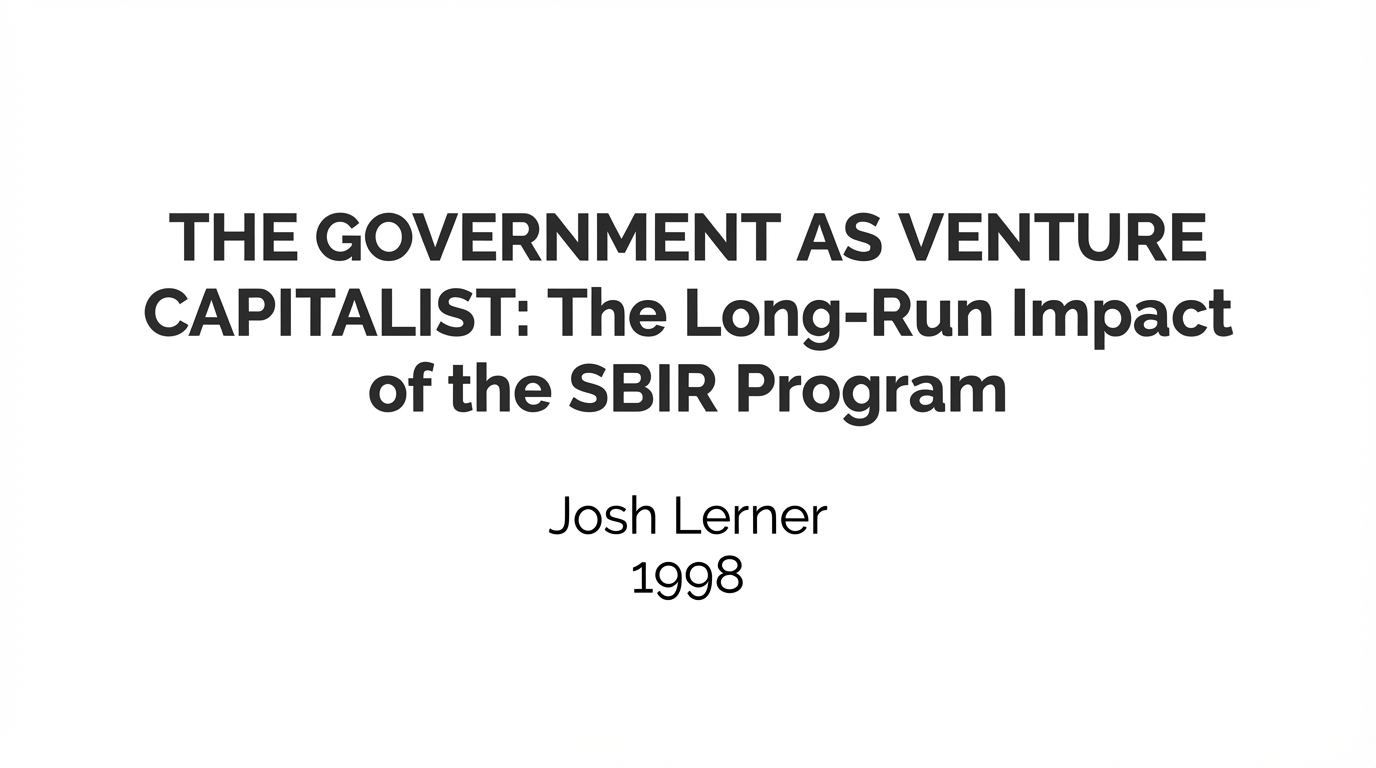
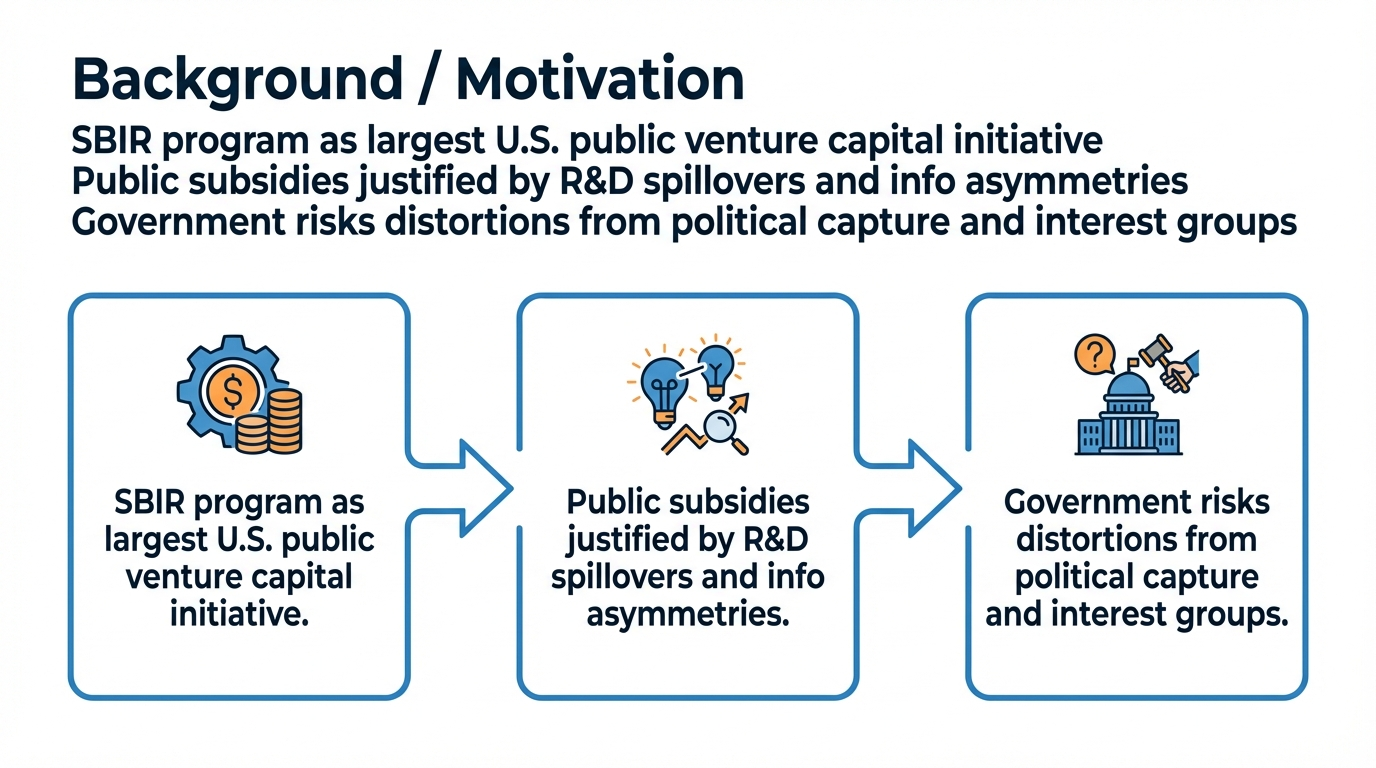
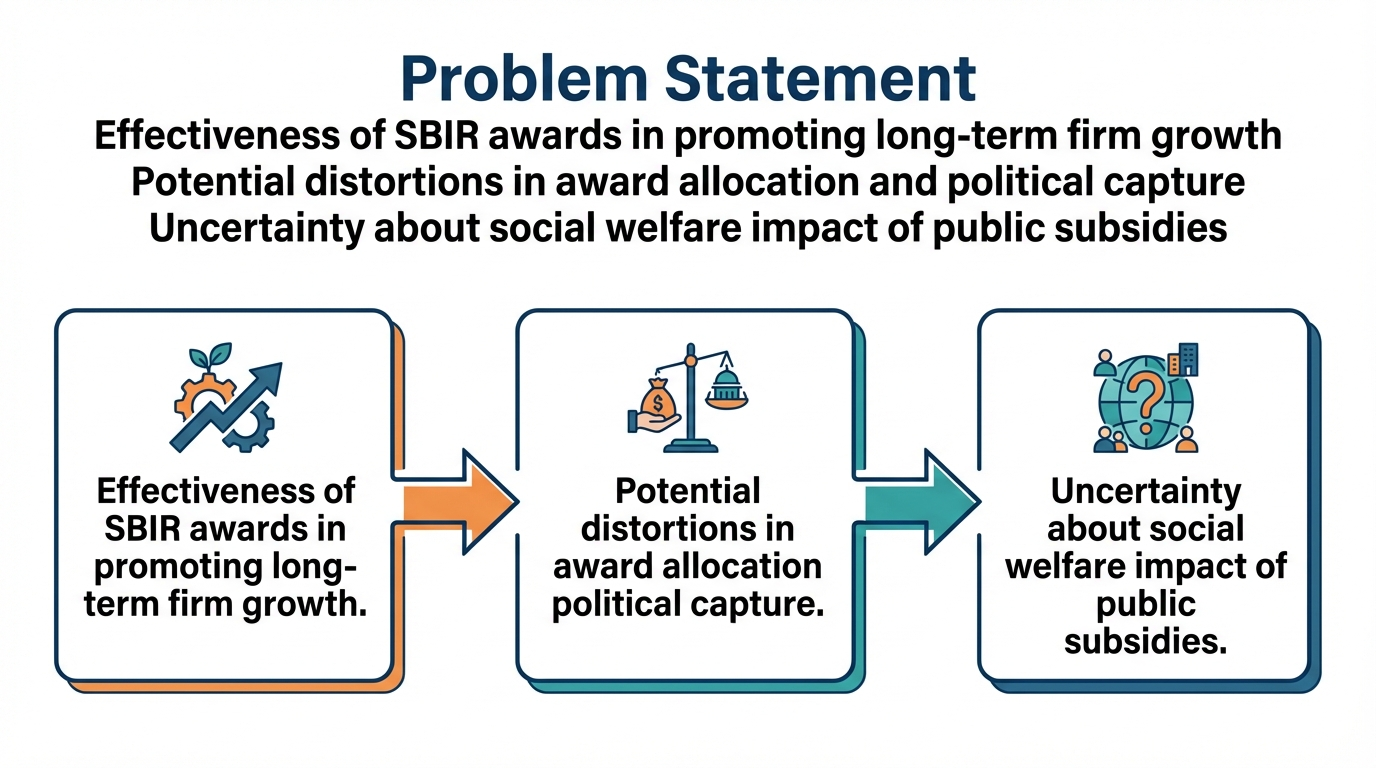
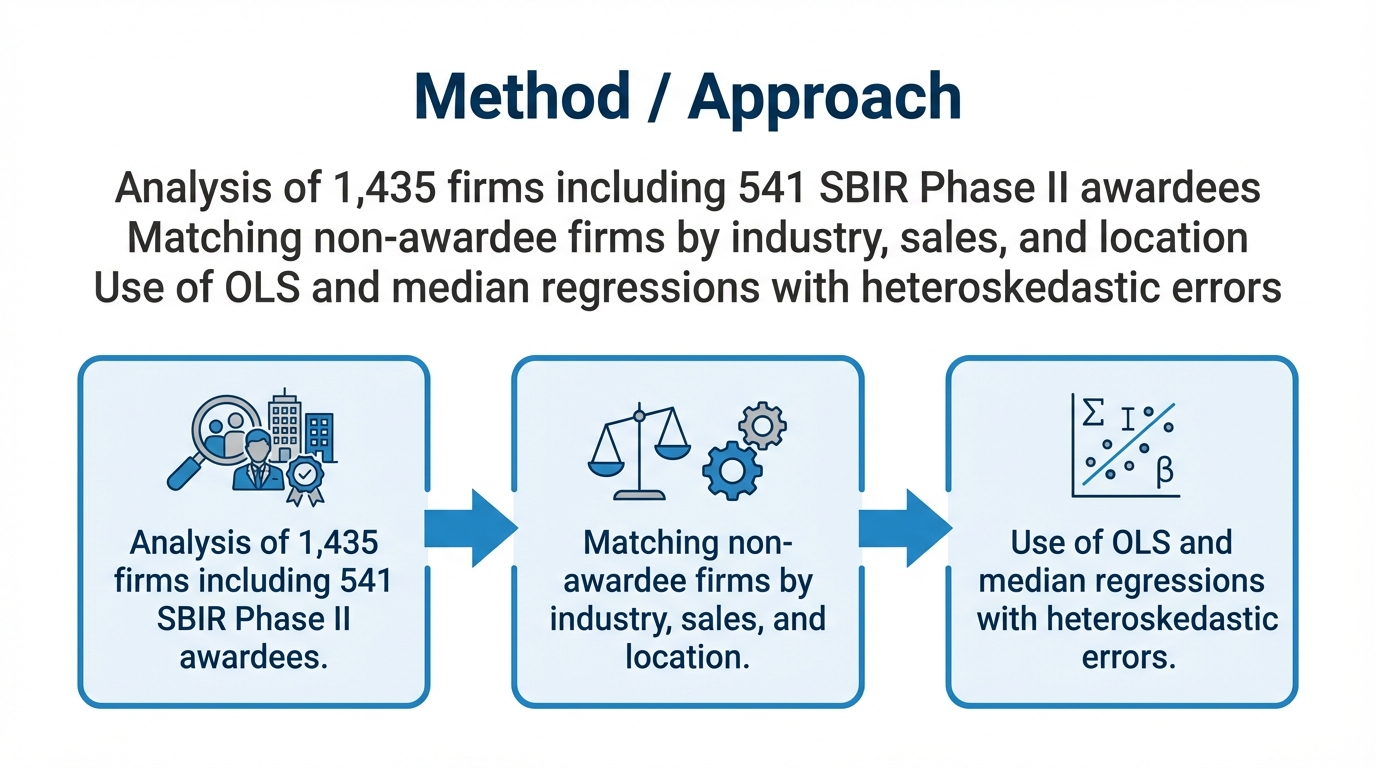
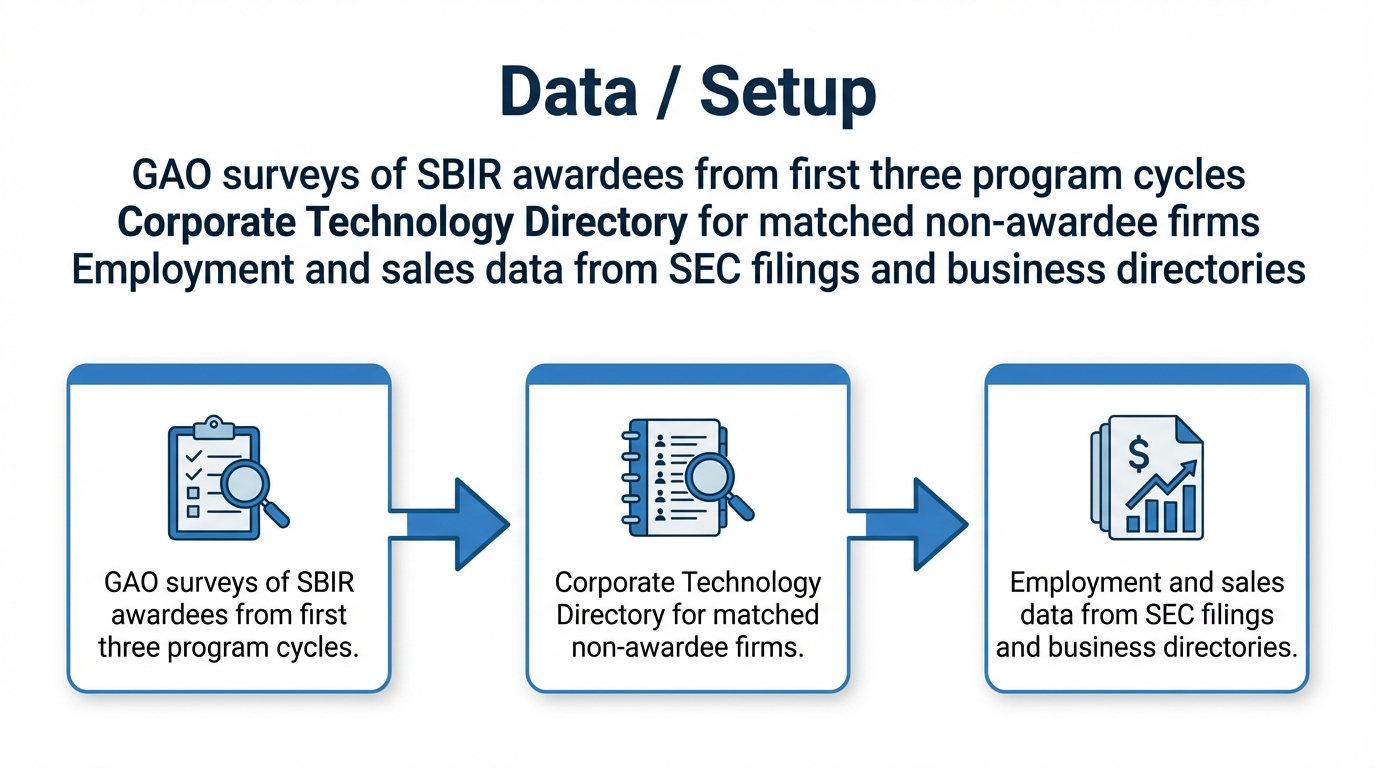
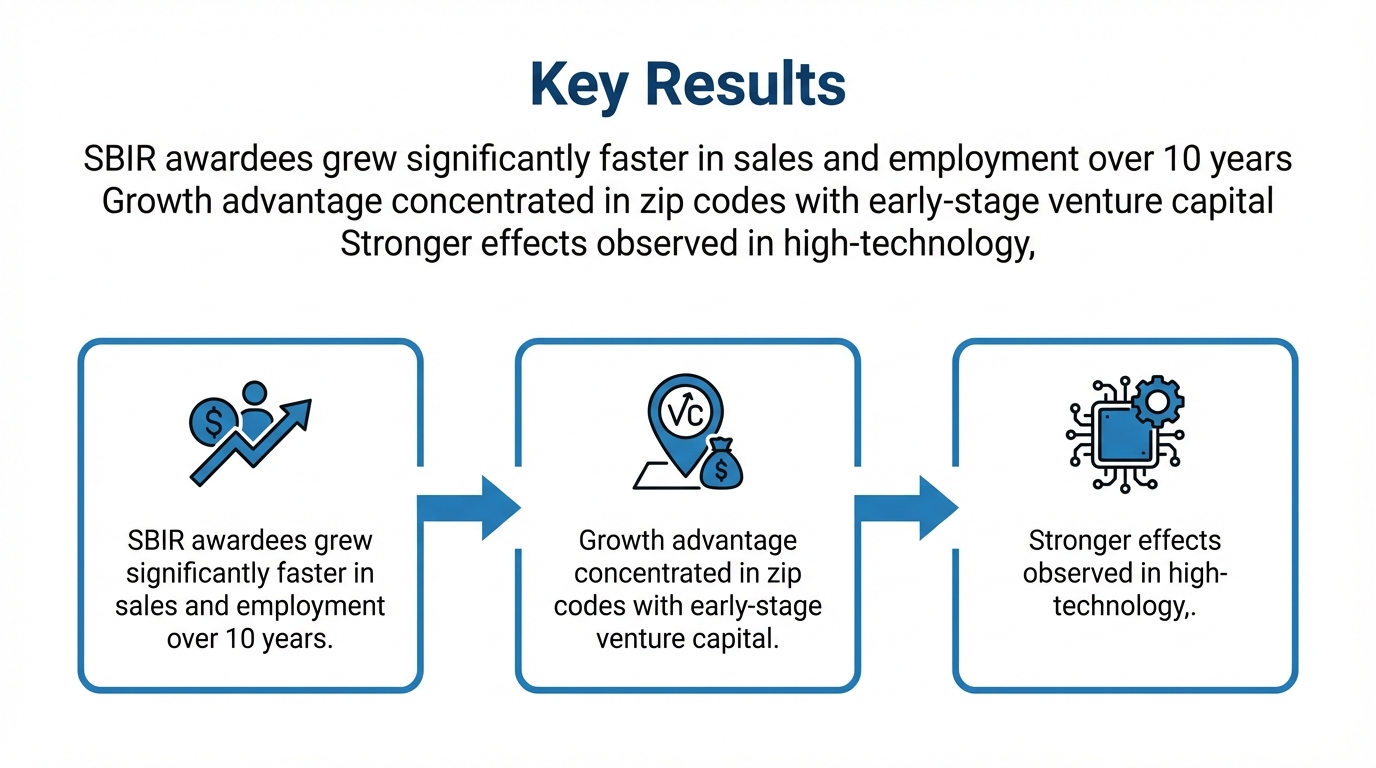
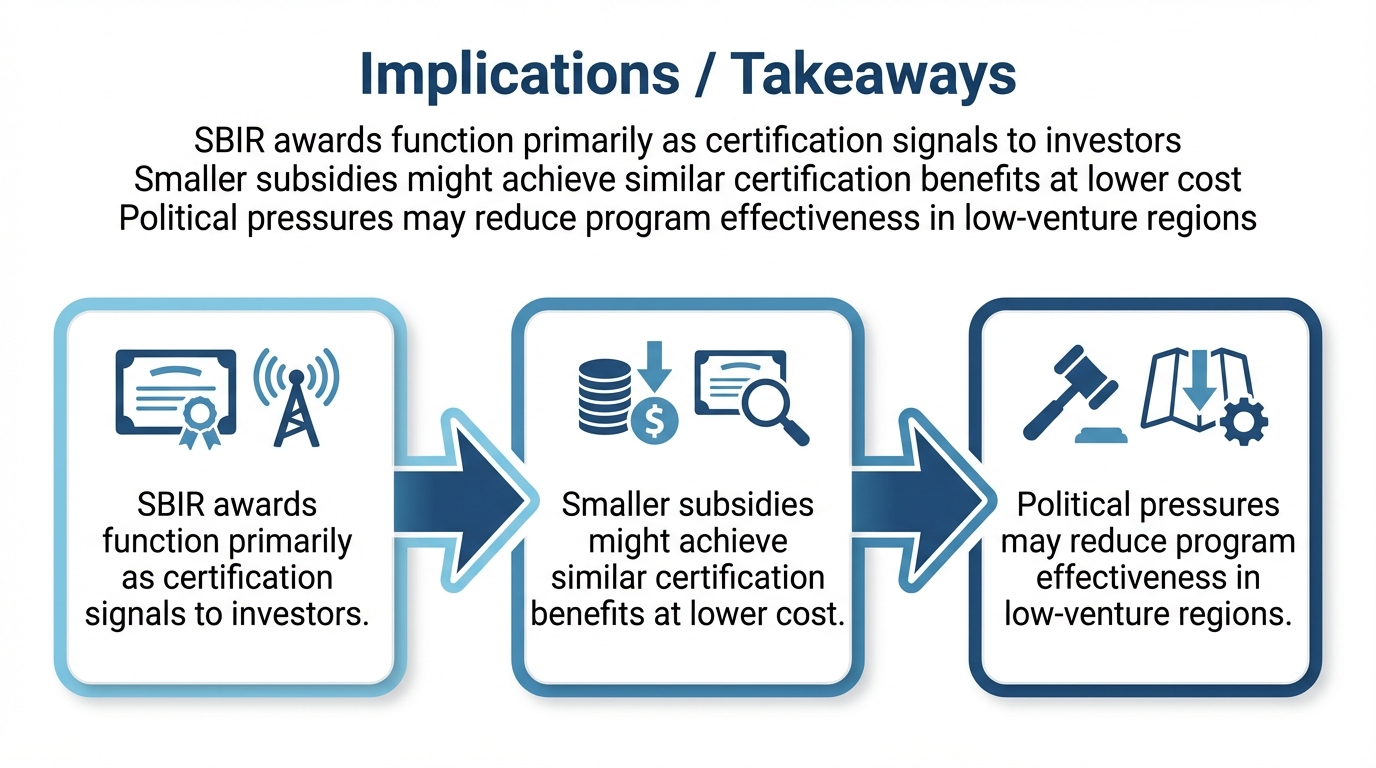

In [47]:
# ============================================================
# Cell 8: In-notebook preview (FINAL slides generated by Gemini)
# ============================================================

import base64
from typing import List

# ------------------------------------------------------------
# Guard
# ------------------------------------------------------------
if not slide_png_paths or len(slide_png_paths) == 0:
    print("⚠️ No slide images found. Please run Cell 7 first.")
else:
    print(f"✅ Found {len(slide_png_paths)} generated slide images")
    print(f"   - slides_dir: {SLIDES_DIR}")

# ------------------------------------------------------------
# Helpers
# ------------------------------------------------------------
def _img_to_data_uri(path: Path) -> str:
    b = Path(path).read_bytes()
    b64 = base64.b64encode(b).decode("utf-8")
    return f"data:image/png;base64,{b64}"

def preview_slides(paths: List[Path], max_items: int = 20):
    cards = []
    for p in paths[:max_items]:
        p = Path(p)
        uri = _img_to_data_uri(p)
        cards.append(f"""
        <div style="margin: 18px 0; padding: 12px; border: 1px solid #e5e7eb; border-radius: 10px;">
          <div style="font-family: sans-serif; font-size: 13px; margin-bottom: 10px;">
            <b>{p.name}</b>
            <span style="color:#6b7280;">&nbsp;({p.stat().st_size/1024:.1f} KB)</span>
          </div>
          <img src="{uri}" style="max-width: 100%; height: auto; border-radius: 8px;" />
        </div>
        """)
    html = "<div>" + "\n".join(cards) + "</div>"
    display(HTML(html))

# ------------------------------------------------------------
# Preview
# ------------------------------------------------------------
if slide_png_paths and len(slide_png_paths) > 0:
    preview_slides([Path(p) for p in slide_png_paths], max_items=MAX_SLIDES)
